In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'
g = torch.Generator(device=device).manual_seed(2147483647) # for reproducibility


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the data set
block_size = 3

def build_dataset(words):
    X,Y = [],[]

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)

            context = context[1:] + [ix]
    
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.randn(fan_out, generator=g) if bias else None

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # learnable params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers --> updated while running
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # move buffers to same device as x
        self.gamma = self.gamma.to(x.device)
        self.beta = self.beta.to(x.device)
        self.running_mean = self.running_mean.to(x.device)
        self.running_var = self.running_var.to(x.device)

        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out


    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        return []



n_embd = 10 # the dimensionality of the charecter embedding vector
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(213) # for reproducibilty

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(            n_hidden,n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(            n_hidden,n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(            n_hidden,n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(            n_hidden,n_hidden), BatchNorm(n_hidden), Tanh(),
    Linear(            n_hidden,vocab_size), BatchNorm(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    # last layer: make less confident
    # layers[-1].weight *= 0.1

    # all other: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))    



for p in parameters:
    p.requires_grad = True
    p.data = p.data.to(device)

47551


In [6]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # learning rate decay
    for p in parameters:
        p.data += p.grad * -lr

    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # if i >= 10000:
    #     break

    

      0/ 200000: 3.290756
  10000/ 200000: 1.880831
  20000/ 200000: 2.326482
  30000/ 200000: 2.099096
  40000/ 200000: 1.951235
  50000/ 200000: 2.263543
  60000/ 200000: 2.249977
  70000/ 200000: 2.229653
  80000/ 200000: 2.072625
  90000/ 200000: 1.739946
 100000/ 200000: 2.292407
 110000/ 200000: 1.804376
 120000/ 200000: 1.860119
 130000/ 200000: 2.274663
 140000/ 200000: 2.273782
 150000/ 200000: 1.843563
 160000/ 200000: 1.988255
 170000/ 200000: 2.455562
 180000/ 200000: 2.010388
 190000/ 200000: 2.099479


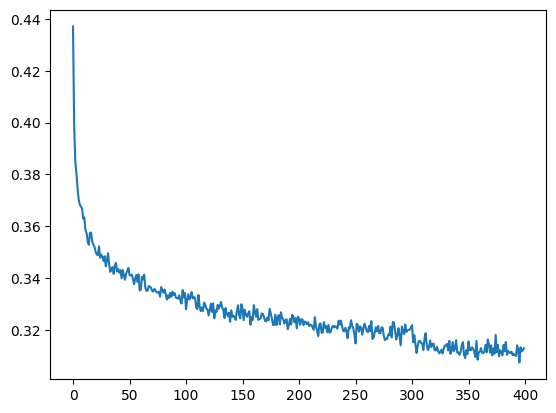

In [22]:
plt.plot(torch.tensor(lossi).view(-1,500).mean(1))

layer 2 (      Tanh): mean -0.02, std 0.69, saturated: 16.28%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 18.28%
layer 8 (      Tanh): mean +0.02, std 0.77, saturated: 19.72%
layer 11 (      Tanh): mean -0.01, std 0.77, saturated: 19.72%
layer 14 (      Tanh): mean -0.02, std 0.80, saturated: 22.56%


Text(0.5, 1.0, 'activation distribution')

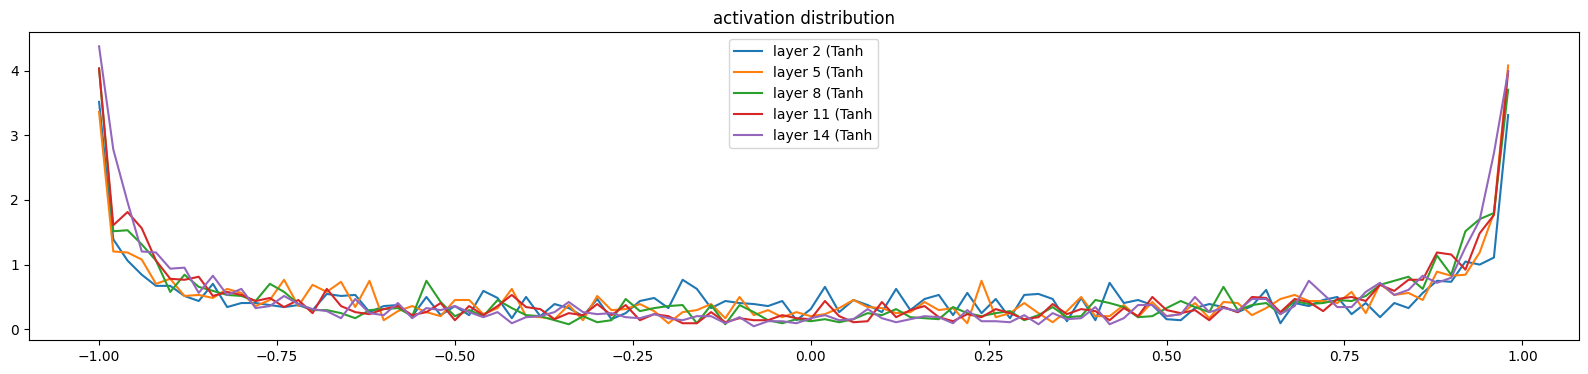

In [7]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t.cpu(), density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 5.748444e-03
layer 5 (      Tanh): mean -0.000000, std 4.816382e-03
layer 8 (      Tanh): mean +0.000000, std 4.521203e-03
layer 11 (      Tanh): mean -0.000000, std 4.306217e-03
layer 14 (      Tanh): mean +0.000000, std 4.270419e-03


Text(0.5, 1.0, 'gradient distribution')

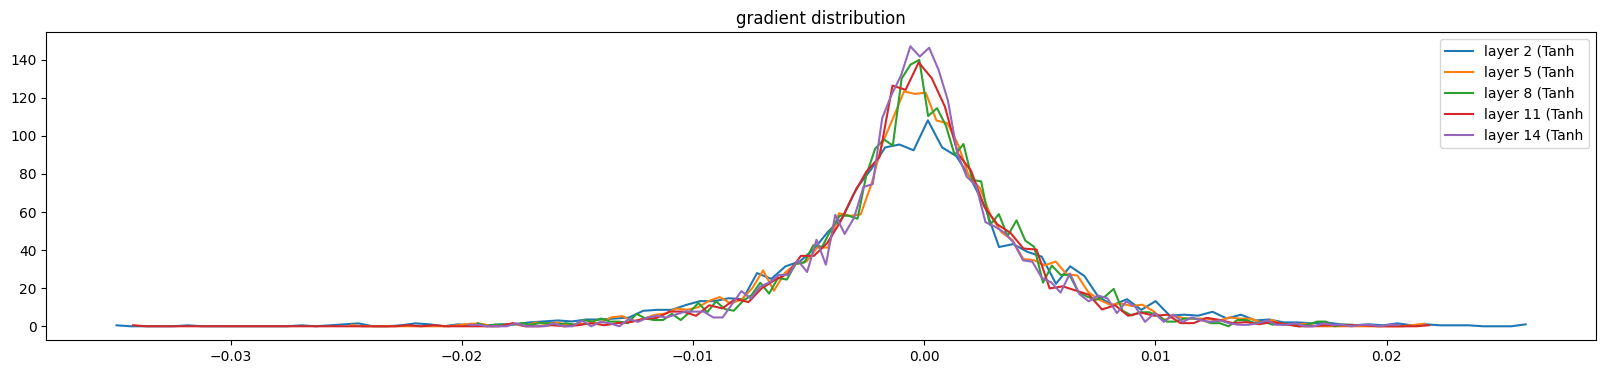

In [8]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t.cpu(), density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean -0.000000 | std 2.064259e-02 | grad:data ratio 1.838448e-02
weight  (30, 100) | mean +0.000042 | std 9.786493e-03 | grad:data ratio 2.187419e-02
weight (100, 100) | mean -0.000001 | std 5.796617e-03 | grad:data ratio 2.130069e-02
weight (100, 100) | mean -0.000126 | std 6.238857e-03 | grad:data ratio 2.303778e-02
weight (100, 100) | mean -0.000081 | std 5.792075e-03 | grad:data ratio 2.209450e-02
weight (100, 100) | mean -0.000040 | std 5.234869e-03 | grad:data ratio 2.086874e-02
weight  (100, 27) | mean +0.000187 | std 8.650454e-03 | grad:data ratio 2.308767e-02


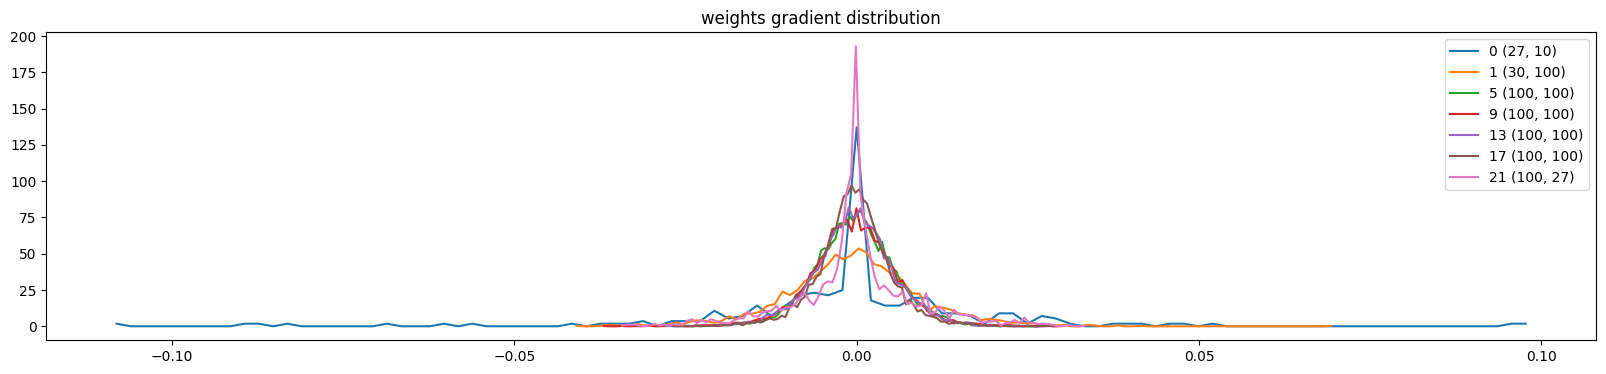

In [9]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t.cpu(), density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

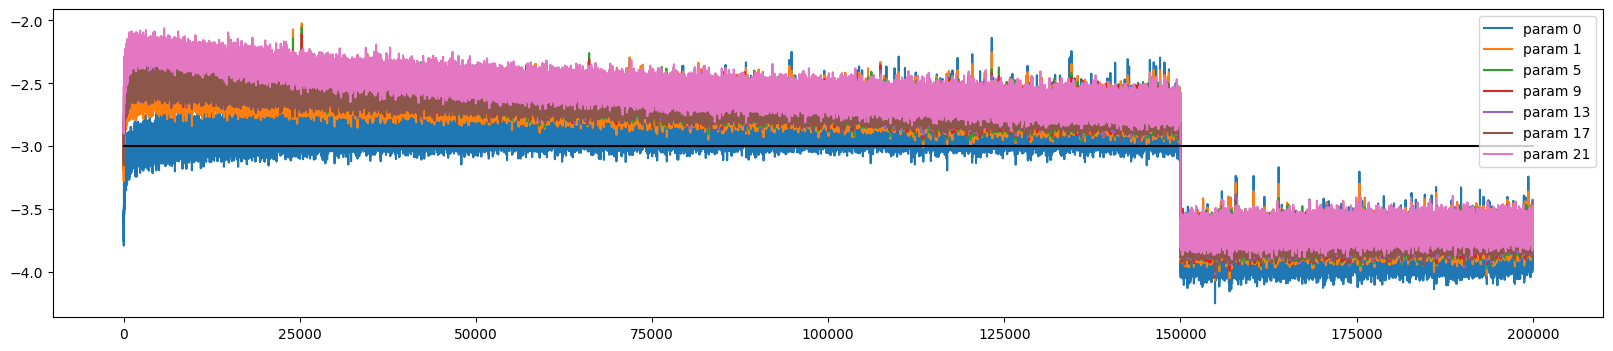

In [10]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [11]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')


train 2.0046567916870117
val 2.0844225883483887


In [16]:
# sample from the model
# g = torch.Generator(device=device).manual_seed(40)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...

    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

kavcianaidanan.
ethy.
kham.
sabrial.
charjina.
eveloni.
ram.
yon.
emmeta.
dor.
don.
seidy.
amina.
jakaig.
daensleiah.
adgayannah.
brion.
lar.
rommonna.
amiyahith.
